# Direct subtraction of PSF from coadd - one patch - Gen3 HSC

Gen3 version of the subtraction notebook, using the hsc datasets on lsst-devl.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from astropy.visualization import ZScaleInterval
from lsst.daf.butler import Butler

%run -n -i "subtraction_defs.py"

Currently available data was queried by the "butler" cmd tool.

In [2]:
butler = Butler("/datasets/hsc/gen3repo/rc2w42_ssw46", collections='RC2/w_2020_42', writeable=False)

skymap = butler.get("deepCoadd_skyMap", skymap='hsc_rings_v1')

coaddexp = butler.get("deepCoadd", band='g', skymap='hsc_rings_v1', tract=9813, patch=78)

srcCat = butler.get('deepCoadd_meas', skymap='hsc_rings_v1', band='g', tract=9813, patch=78)

In [3]:
flt = ((srcCat['deblend_nChild']==0) & srcCat['deblend_deblendedAsPsf']
        & (~srcCat['base_PixelFlags_flag_edge']) & ~srcCat['base_PixelFlags_flag_bad'])
# flt = srcCat['detect_isPrimary'] # merge_peak_sky == False & inner tract, patch & nChild ==0
goodSrc = srcCat[flt]
i_s = np.argsort(goodSrc['base_PsfFlux_instFlux'])
N = len(goodSrc)
flt = np.zeros(len(goodSrc), dtype=bool)
# Get the sources with brightness in the 95-96th percentile
flt[i_s[int(0.95*N):int(0.96*N)]] = True
goodSrc = goodSrc[flt]

In [4]:
print(coaddexp.getBBox())
bbox = coaddexp.getBBox()

(minimum=(23900, 31900), maximum=(28099, 35999))


<IPython.core.display.Javascript object>


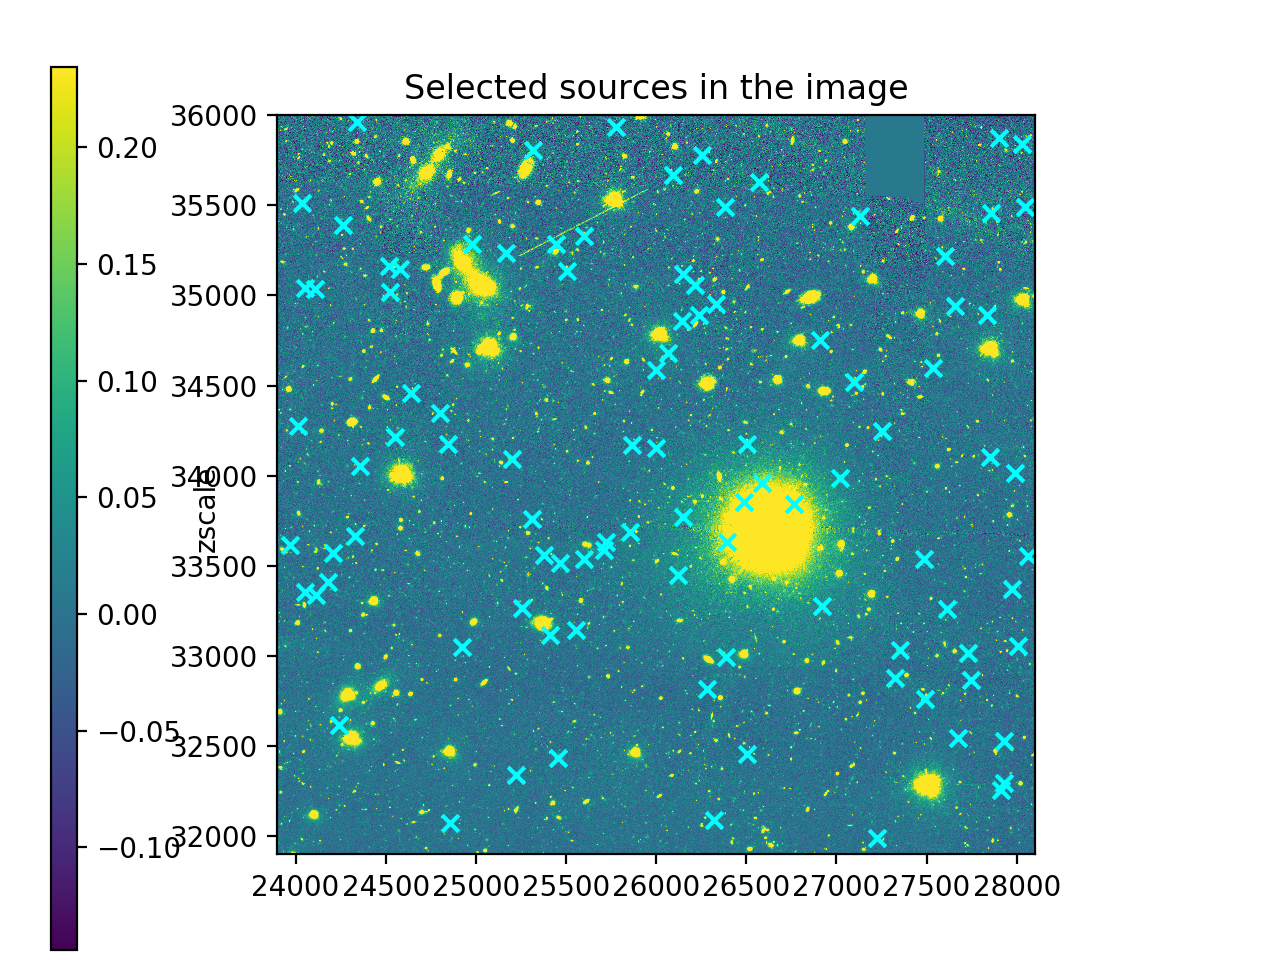

In [5]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(coaddexp.image.array)
bbox = coaddexp.getBBox()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cb = ax.imshow(coaddexp.image.array, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax,
              extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])
# ax.scatter(srcCat['base_NaiveCentroid_x'][i_goodSrc], srcCat['base_NaiveCentroid_y'][i_goodSrc],
#            marker='+', color='red')
ax.scatter(goodSrc['base_SdssCentroid_x'], goodSrc['base_SdssCentroid_y'],
             marker='x', color='cyan')
ax.set_title("Selected sources in the image")
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax, label='zscale')

### Subtraction on one source

In [6]:
res = getCutoutAndPsf(coaddexp, goodSrc[10])

Image cutout

<IPython.core.display.Javascript object>


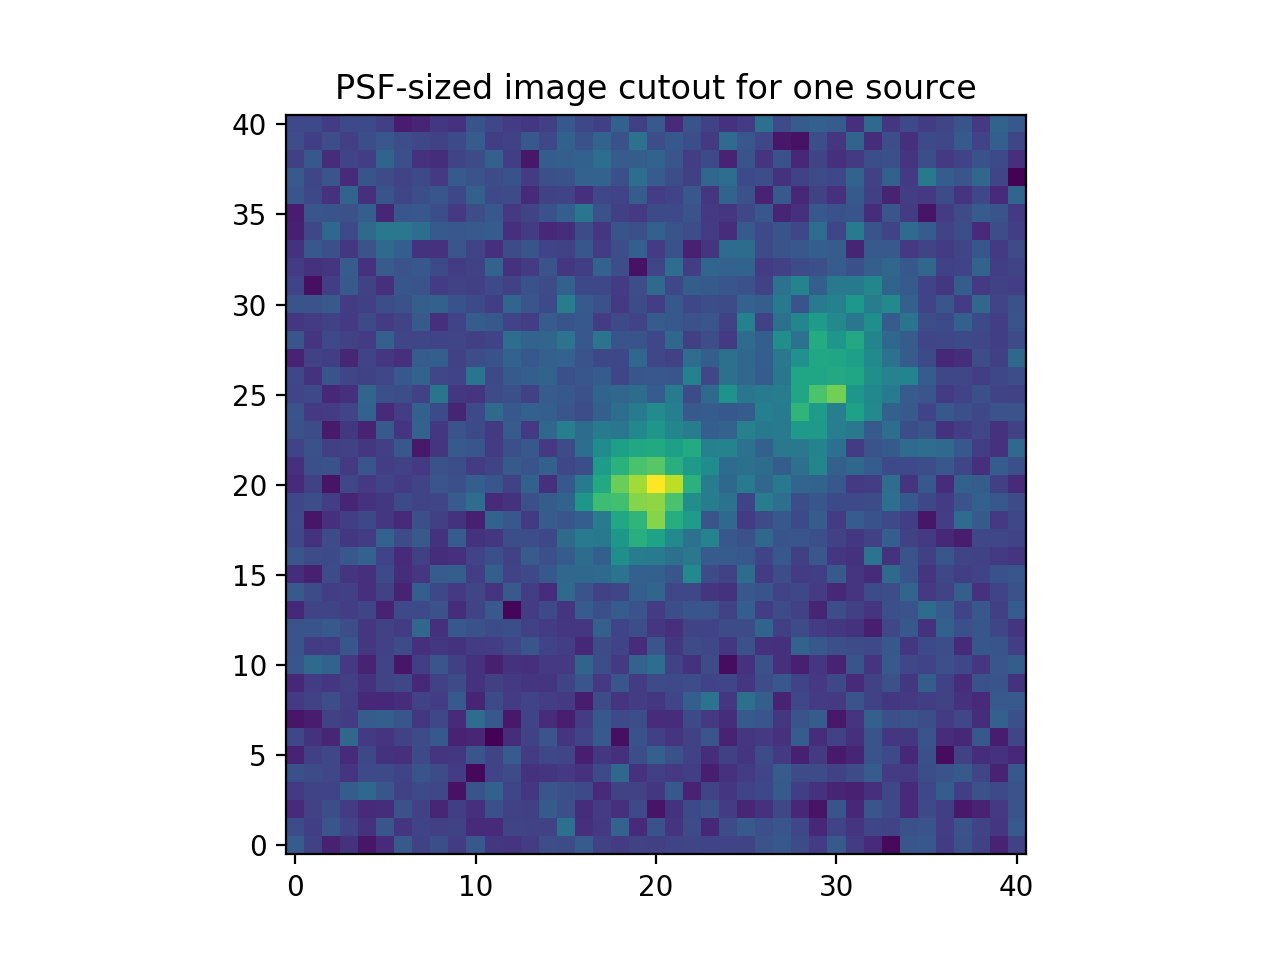

Text(0.5, 1.0, 'PSF-sized image cutout for one source')

In [7]:
# Source cutout of the calexp
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(res.cutExp.image.array, origin='bottom', interpolation='none')
ax.set_title("PSF-sized image cutout for one source")

In [8]:
# Test the minimization in this case
resD = minimizeDiff(res.cutExp, res.psfIm)

Residual image

<IPython.core.display.Javascript object>


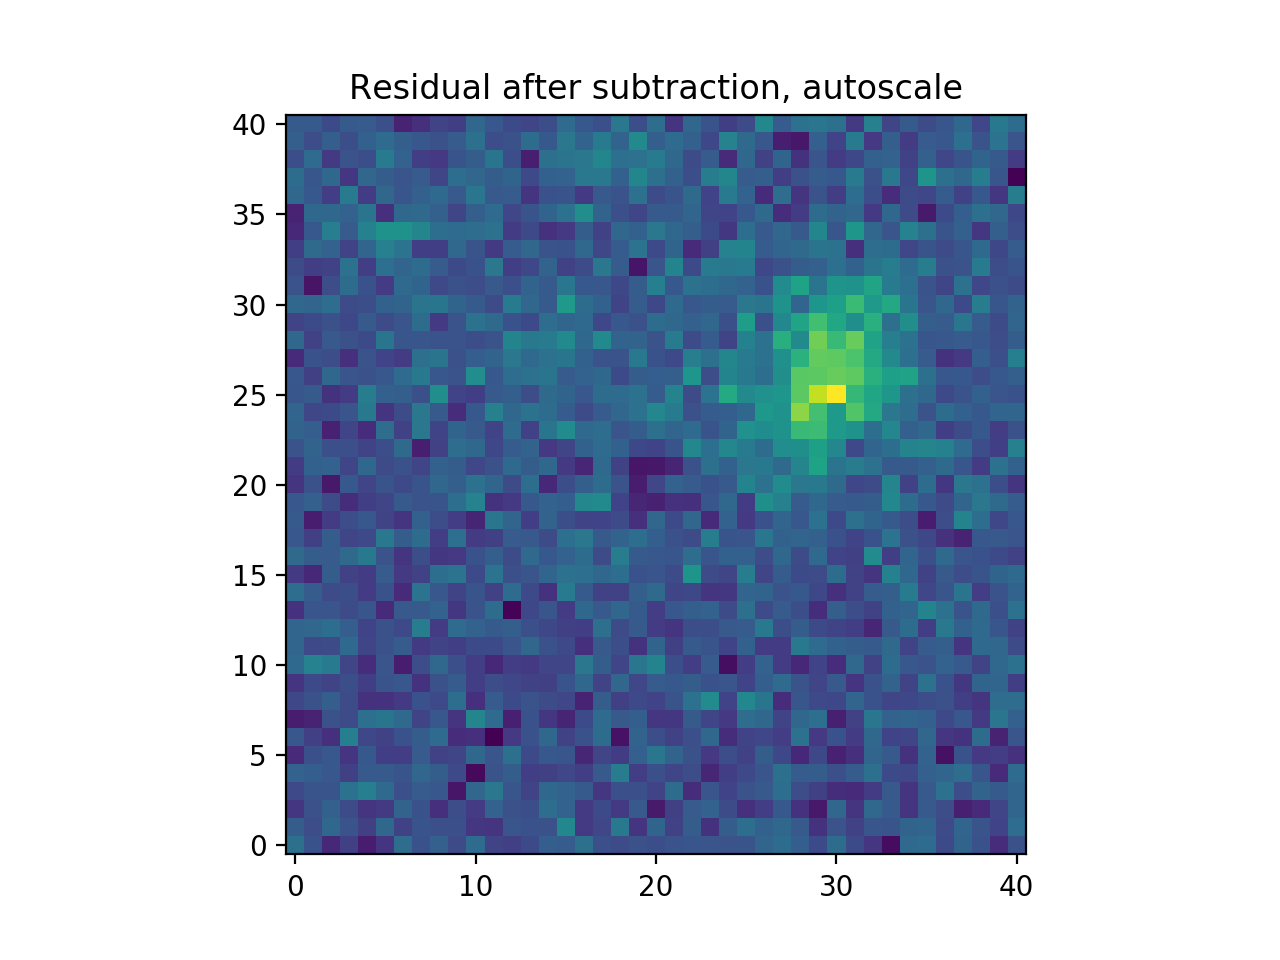

Text(0.5, 1.0, 'Residual after subtraction, autoscale')

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(resD.diffArr, origin='bottom', interpolation='none')
ax.set_title("Residual after subtraction, autoscale")

In [10]:
medianVar = np.median(coaddexp.variance.array)

-------

### Sanity check our minimization

If the two images are identical and differ only by a factor of 2 then the optimal solution
should be equal to 2.

In [11]:
%run -n -i "subtraction_defs.py"

In [12]:
im2 = res.cutExp.clone()
im2.image /= 2.
resD = minimizeDiff(res.cutExp, im2.image)

In [13]:
print(resD.x)

1.9999999999999982


-------

### Loop through good sources
Simple subtraction by optimizing the PSF multiplicative factor only

<IPython.core.display.Javascript object>


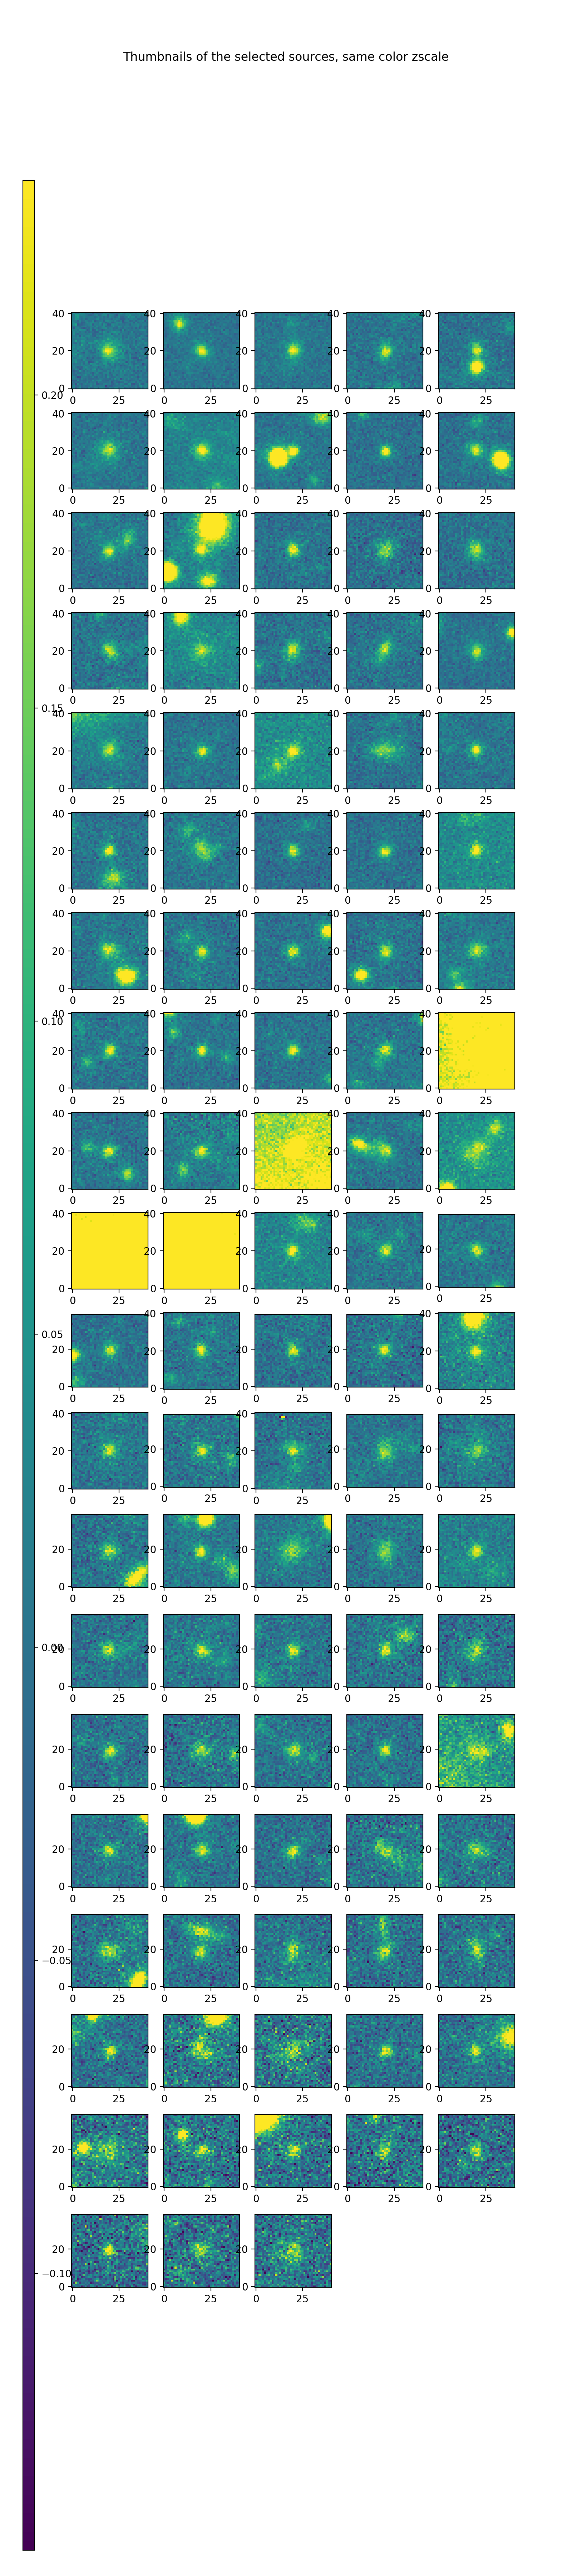

<IPython.core.display.Javascript object>


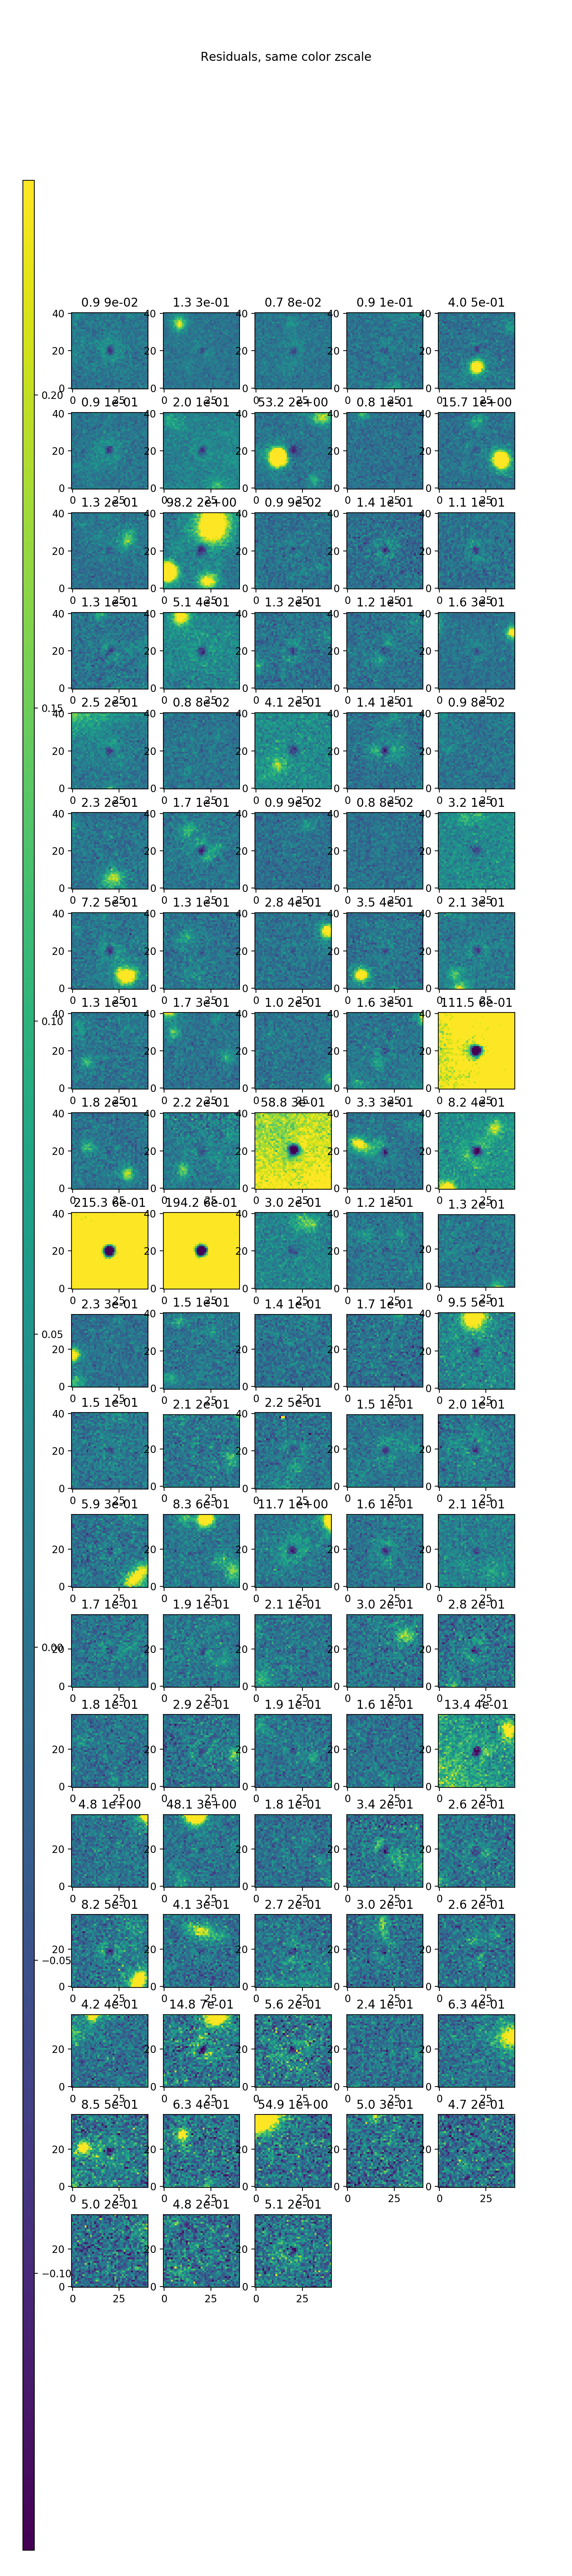

Text(0.5, 0.98, 'Residuals, same color zscale')

In [14]:
axPerRow = 5
nRows = len(goodSrc) // axPerRow + 1
fig_orig = plt.figure(figsize=(8, nRows*1.8))
fig = plt.figure(figsize=(8, nRows*1.8))

i_ax = 1
for src in goodSrc:
    res = getCutoutAndPsf(coaddexp, src)
    resD = minimizeDiff(res.cutExp, res.psfIm)
    chi2perDof = resD.chi2 / medianVar / resD.diffArr.size
    
    ax = fig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig = fig_orig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig.imshow(res.cutExp.image.array, origin='bottom', interpolation='none', 
                   vmin=vmin, vmax=vmax)
    A = resD.diffArr
    cb = ax.imshow(A, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{chi2perDof:.1f} {np.max(A):.0e}")
    i_ax += 1
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax)
ax = fig_orig.add_axes((0.04,0.01,0.02,0.92))
fig_orig.colorbar(cb, cax=ax)
fig_orig.suptitle("Thumbnails of the selected sources, same color zscale")
fig.suptitle("Residuals, same color zscale")

Top-left: residual chi2 per pixel. Top-right: maximum value of residual image.

 * For sources with apparent additional secondary source in the cutout (e.g. 3rd row 2nd col; last one) the residual minimization results in oversubtraction. The negative residual of the primary source can be seen in the center and a positive residual of the satellite source. Also this is reflected by the higher chi2 per dof value.
 * Single sources are well subtracted, with chi2 per dof (pixel) around 1.0. This indicates that the median pixel noise was well reproduced on the residual. (The PSF image is noiseless.)


------